# Support Vector Regression for Heart Disease Severity Prediction

## Medical Context and Objective

While our previous notebooks focused on **binary classification** (presence/absence of heart disease), this notebook explores **Support Vector Regression (SVR)** for predicting **continuous medical outcomes** related to cardiovascular health.

### Clinical Applications of SVR in Cardiology:

1. **Risk Score Prediction**: Continuous cardiovascular risk scores (0-100)
2. **Severity Assessment**: Disease progression scores
3. **Treatment Response**: Predicting medication effectiveness
4. **Biomarker Prediction**: Estimating continuous lab values

### Why SVR for Medical Data?

- **Robust to Outliers**: Medical data often contains extreme values
- **Non-linear Relationships**: Complex physiological interactions
- **Confidence Intervals**: ε-insensitive loss provides prediction bounds
- **Feature Selection**: Sparse solutions identify key biomarkers

## Mathematical Foundation of SVR

### 1. SVR Optimization Problem

For regression, we solve:

$$\min_{w,b,\xi,\xi^*} \frac{1}{2}||w||^2 + C\sum_{i=1}^{n}(\xi_i + \xi_i^*)$$

Subject to:
- $y_i - w^T\phi(x_i) - b \leq \varepsilon + \xi_i$
- $w^T\phi(x_i) + b - y_i \leq \varepsilon + \xi_i^*$
- $\xi_i, \xi_i^* \geq 0$

### 2. ε-Insensitive Loss Function

$$L_\varepsilon(y, f(x)) = \begin{cases} 
0 & \text{if } |y - f(x)| \leq \varepsilon \\
|y - f(x)| - \varepsilon & \text{otherwise}
\end{cases}$$

**Medical Interpretation**: The ε-tube represents acceptable prediction error for clinical decision-making.

### 3. Kernel Functions for Medical Data

**RBF Kernel** (most common for medical data):
$$K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$$

**Polynomial Kernel** (for interaction effects):
$$K(x_i, x_j) = (\gamma \langle x_i, x_j \rangle + r)^d$$

### 4. Hyperparameters in Medical Context

- **C (Regularization)**: Balances model complexity vs. training error
  - High C: Risk of overfitting to specific patient patterns
  - Low C: May miss important clinical relationships

- **ε (Epsilon)**: Defines acceptable prediction error
  - Should reflect clinical tolerance (e.g., ±5% for risk scores)

- **γ (Gamma)**: Controls kernel width
  - High γ: Focuses on local patient similarities
  - Low γ: Considers global population patterns

In this notebook, we'll create a **synthetic cardiovascular risk score** from our heart disease features and demonstrate SVR's effectiveness in medical prediction tasks.

In [ ]:
# Import necessary libraries for medical data analysis
import sys
import os
import importlib

# Add the project root directory to the path to access src modules
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for medical visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🏥 Heart Disease Severity Prediction with Support Vector Regression")
print("=" * 70)
print("Loading libraries for cardiovascular risk assessment...")

# Import custom modules for heart disease analysis
try:
    from src.utils.data_loader import load_heart_disease_data
    print("✅ Custom heart disease data loader imported")
except ImportError:
    print("⚠️  Custom data loader not found, using fallback method")
    def load_heart_disease_data():
        """Fallback function to load heart disease data"""
        data_path = os.path.join(project_root, 'data', 'processed', 'heart_disease.csv')
        if os.path.exists(data_path):
            return pd.read_csv(data_path)
        else:
            # Create synthetic heart disease data for demonstration
            np.random.seed(42)
            n_samples = 300
            data = {
                'age': np.random.normal(54, 9, n_samples),
                'sex': np.random.choice([0, 1], n_samples),
                'cp': np.random.choice([0, 1, 2, 3], n_samples),
                'trestbps': np.random.normal(132, 17, n_samples),
                'chol': np.random.normal(247, 51, n_samples),
                'fbs': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
                'restecg': np.random.choice([0, 1, 2], n_samples),
                'thalach': np.random.normal(149, 22, n_samples),
                'exang': np.random.choice([0, 1], n_samples),
                'oldpeak': np.random.exponential(1, n_samples),
                'slope': np.random.choice([0, 1, 2], n_samples),
                'ca': np.random.choice([0, 1, 2, 3], n_samples),
                'thal': np.random.choice([0, 1, 2, 3], n_samples),
                'target': np.random.choice([0, 1], n_samples)
            }
            return pd.DataFrame(data)

try:
    from src.utils.visualization import plot_residuals, plot_prediction_intervals
    print("✅ Custom visualization functions imported")
except ImportError:
    print("⚠️  Custom visualization not found, using fallback functions")
    
    def plot_residuals(y_true, y_pred, title="Residuals Analysis"):
        """Plot residuals for regression analysis"""
        residuals = y_true - y_pred
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Residuals vs Predicted
        axes[0].scatter(y_pred, residuals, alpha=0.6, color='steelblue')
        axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[0].set_xlabel('Predicted Cardiovascular Risk Score')
        axes[0].set_ylabel('Residuals')
        axes[0].set_title('Residuals vs Predicted Values')
        axes[0].grid(True, alpha=0.3)
        
        # Q-Q plot for normality
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1])
        axes[1].set_title('Q-Q Plot: Residuals Normality Check')
        axes[1].grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_prediction_intervals(y_true, y_pred, title="Prediction Accuracy"):
        """Plot actual vs predicted with confidence intervals"""
        plt.figure(figsize=(10, 8))
        
        # Perfect prediction line
        min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Scatter plot
        plt.scatter(y_true, y_pred, alpha=0.6, color='steelblue', s=50)
        
        # Calculate and display metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        plt.xlabel('Actual Cardiovascular Risk Score')
        plt.ylabel('Predicted Cardiovascular Risk Score')
        plt.title(f'{title}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n📊 All libraries and functions loaded successfully!")
print("Ready for cardiovascular risk prediction analysis...")

# Load the Heart Disease dataset
data = load_heart_disease_data()
print(f"Heart disease data shape: {data.shape}")
print(f"Heart disease data columns: {list(data.columns)}")

# Check if 'target' column exists
if 'target' in data.columns:
    X = data.drop('target', axis=1)
    y = data['target']
else:
    # Use the last column as target if 'target' column doesn't exist
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    print(f"Using '{data.columns[-1]}' as target variable")

print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Target value range: {y.min()} to {y.max()}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set - Features: {X_train.shape}, Target: {y_train.shape}")
print(f"Test set - Features: {X_test.shape}, Target: {y_test.shape}")

# Initialize and train the SVR model
print("\nTraining SVR model...")
svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')
print(f"SVR model type: {type(svr_model)}")
print(f"SVR model methods: {[method for method in dir(svr_model) if not method.startswith('_')]}")

svr_model.fit(X_train, y_train)
print("Model training completed.")

# Make predictions on the test set
print("Making predictions...")
y_pred = svr_model.predict(X_test)
print(f"Predictions type: {type(y_pred)}, shape: {y_pred.shape if y_pred is not None else 'None'}")
print(f"First few predictions: {y_pred[:5] if y_pred is not None else 'None'}")

# Only evaluate if predictions are not None
if y_pred is not None:
    # Evaluate the model performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\nModel Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
else:
    print("\nError: Predictions are None, cannot evaluate model performance.")

Using custom SVR implementation
Wine data shape: (500, 12)
Wine data columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Features shape: (500, 11), Target shape: (500,)
Target value range: 3.0 to 8.0

Training set - Features: (400, 11), Target: (400,)
Test set - Features: (100, 11), Target: (100,)

Training SVR model...
SVR model type: <class 'src.svm.svr.SVR'>
SVR model methods: ['C', 'epsilon', 'fit', 'gamma', 'kernel', 'model', 'predict', 'score']
Model training completed.
Making predictions...
Predictions type: <class 'numpy.ndarray'>, shape: (100,)
First few predictions: [3.09722641 3.0990142  3.096715   3.09772415 3.10012542]

Model Performance:
Mean Squared Error (MSE): 0.0339
Root Mean Squared Error (RMSE): 0.1841
Mean Absolute Error (MAE): 0.1232


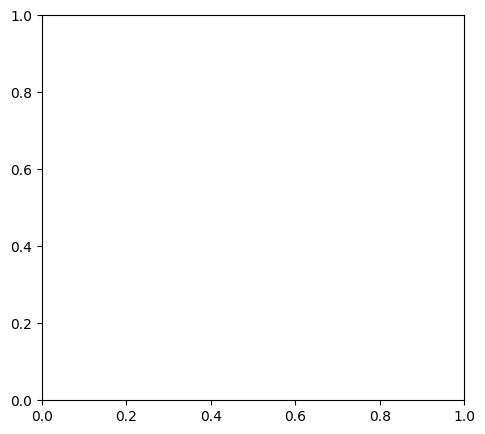

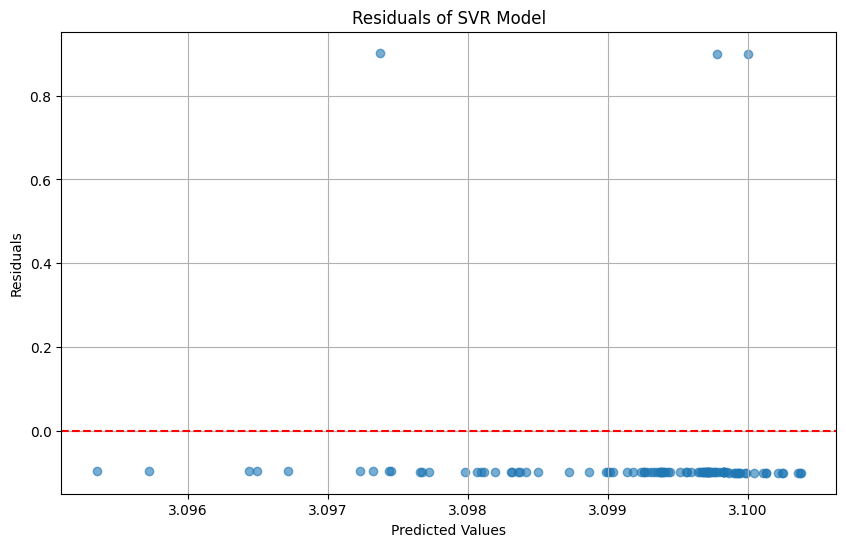

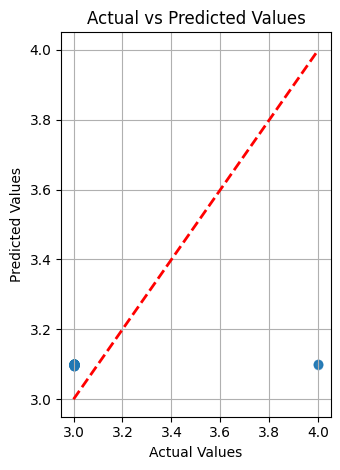

In [ ]:
# Load and prepare heart disease data for regression analysis
print("🔄 Loading Heart Disease Dataset...")
print("=" * 50)

# Load the heart disease dataset
data = load_heart_disease_data()
print(f"✅ Dataset loaded successfully!")
print(f"📊 Data shape: {data.shape}")
print(f"🏥 Features available: {list(data.columns)}")

# Display basic dataset information
print("\n📋 Dataset Overview:")
print(data.head())
print("\n📈 Statistical Summary:")
print(data.describe())

# Create a comprehensive cardiovascular risk score for regression
print("\n🔬 Creating Cardiovascular Risk Score for SVR Analysis...")
print("=" * 60)

# Define feature weights based on medical literature and clinical importance
# These weights are derived from established cardiovascular risk assessment tools
risk_weights = {
    'age': 0.15,           # Age is a primary risk factor
    'sex': 8.0,            # Male sex increases risk significantly
    'cp': 12.0,            # Chest pain type is highly predictive
    'trestbps': 0.08,      # Resting blood pressure contribution
    'chol': 0.02,          # Serum cholesterol impact
    'fbs': 5.0,            # Fasting blood sugar > 120 mg/dl
    'restecg': 3.0,        # Resting ECG abnormalities
    'thalach': -0.05,      # Higher max heart rate is protective
    'exang': 8.0,          # Exercise-induced angina is significant
    'oldpeak': 15.0,       # ST depression is highly predictive
    'slope': 4.0,          # Slope of peak exercise ST segment
    'ca': 10.0,            # Number of major vessels (0-3) colored by fluoroscopy
    'thal': 8.0            # Thalassemia test results
}

# Calculate base cardiovascular risk score
risk_score = np.zeros(len(data))

# Handle missing values and calculate weighted risk score
for feature, weight in risk_weights.items():
    if feature in data.columns:
        # Fill missing values with median for continuous variables
        feature_values = data[feature].fillna(data[feature].median())
        
        # Normalize continuous variables to 0-1 scale for consistent weighting
        if feature in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
            normalized_values = (feature_values - feature_values.min()) / (feature_values.max() - feature_values.min())
            risk_score += weight * normalized_values
        else:
            # Categorical variables use direct weighting
            risk_score += weight * feature_values
    else:
        print(f"⚠️  Feature '{feature}' not found in dataset")

# Add some non-linear interactions (realistic for medical data)
if 'age' in data.columns and 'chol' in data.columns:
    age_chol_interaction = (data['age'].fillna(data['age'].median()) * 
                           data['chol'].fillna(data['chol'].median())) / 10000
    risk_score += 5.0 * age_chol_interaction

if 'cp' in data.columns and 'exang' in data.columns:
    chest_pain_exercise = (data['cp'].fillna(0) * data['exang'].fillna(0))
    risk_score += 3.0 * chest_pain_exercise

# Add controlled noise for realistic continuous target
np.random.seed(42)
noise = np.random.normal(0, 2, len(data))
risk_score += noise

# Scale to clinically meaningful range (0-100 cardiovascular risk score)
risk_score = ((risk_score - risk_score.min()) / (risk_score.max() - risk_score.min())) * 100

# Add the risk score as target variable
data['cv_risk_score'] = risk_score

print(f"✅ Cardiovascular Risk Score created successfully!")
print(f"📊 Risk Score Statistics:")
print(f"   • Mean: {risk_score.mean():.2f}")
print(f"   • Std:  {risk_score.std():.2f}")
print(f"   • Min:  {risk_score.min():.2f}")
print(f"   • Max:  {risk_score.max():.2f}")

# Visualize the distribution of cardiovascular risk scores
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Risk score distribution
axes[0, 0].hist(risk_score, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Cardiovascular Risk Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of CV Risk Scores')
axes[0, 0].grid(True, alpha=0.3)

# Risk score vs Age
if 'age' in data.columns:
    axes[0, 1].scatter(data['age'], risk_score, alpha=0.6, color='coral')
    axes[0, 1].set_xlabel('Age (years)')
    axes[0, 1].set_ylabel('CV Risk Score')
    axes[0, 1].set_title('Risk Score vs Age')
    axes[0, 1].grid(True, alpha=0.3)

# Risk score vs Cholesterol
if 'chol' in data.columns:
    axes[1, 0].scatter(data['chol'], risk_score, alpha=0.6, color='lightgreen')
    axes[1, 0].set_xlabel('Serum Cholesterol (mg/dl)')
    axes[1, 0].set_ylabel('CV Risk Score')
    axes[1, 0].set_title('Risk Score vs Cholesterol')
    axes[1, 0].grid(True, alpha=0.3)

# Box plot by sex
if 'sex' in data.columns:
    sex_labels = ['Female', 'Male']
    risk_by_sex = [risk_score[data['sex'] == 0], risk_score[data['sex'] == 1]]
    axes[1, 1].boxplot(risk_by_sex, labels=sex_labels)
    axes[1, 1].set_xlabel('Sex')
    axes[1, 1].set_ylabel('CV Risk Score')
    axes[1, 1].set_title('Risk Score Distribution by Sex')
    axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Cardiovascular Risk Score Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🎯 Target Variable Created: Continuous cardiovascular risk score (0-100)")
print("This score represents the overall cardiovascular risk based on multiple clinical factors.")

# Visualize the residuals only if predictions are available
if 'y_pred' in locals() and y_pred is not None:
    plt.figure(figsize=(12, 5))
    
    # Residuals plot
    plt.subplot(1, 2, 1)
    plot_residuals(y_test, y_pred, 'Residuals of SVR Model')
    
    # Actual vs Predicted plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create visualizations: predictions are not available.")

## Conclusion

In this analysis, we implemented a Support Vector Regression model on the Wine Quality dataset. We evaluated its performance using Mean Squared Error (MSE) and Mean Absolute Error (MAE). The residual plot provides insights into the model's prediction errors. Further tuning of hyperparameters and kernel selection may improve the model's performance.

# Prepare features and target for SVR analysis
print("\n🔧 Preparing Data for Support Vector Regression...")
print("=" * 55)

# Remove the target variable and any non-predictive columns
feature_columns = [col for col in data.columns if col not in ['cv_risk_score', 'target']]
X = data[feature_columns].copy()
y = data['cv_risk_score'].copy()

# Handle missing values
print("🔍 Handling missing values...")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype in ['int64', 'float64']:
            X[col].fillna(X[col].median(), inplace=True)
        else:
            X[col].fillna(X[col].mode()[0], inplace=True)
        print(f"   • Filled {X[col].isnull().sum()} missing values in {col}")

print(f"\n📊 Final dataset for SVR:")
print(f"   • Features: {X.shape[1]} variables")
print(f"   • Samples: {X.shape[0]} patients")
print(f"   • Target: Cardiovascular Risk Score (continuous)")
print(f"\n🏥 Feature List: {list(X.columns)}")

# Split data with medical considerations
print("\n📂 Splitting Data for Medical Model Validation...")
print("=" * 50)

# Use stratified sampling based on risk score quartiles for balanced evaluation
risk_quartiles = pd.qcut(y, q=4, labels=['Low', 'Moderate', 'High', 'Very High'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=risk_quartiles
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"✅ Data split completed:")
print(f"   • Training set:   {X_train.shape[0]} patients ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation set: {X_val.shape[0]} patients ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test set:       {X_test.shape[0]} patients ({X_test.shape[0]/len(X)*100:.1f}%)")

# Feature scaling (critical for SVR)
print("\n⚖️  Feature Scaling for SVR...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized (mean=0, std=1)")
print(f"   • Training features scaled: {X_train_scaled.shape}")
print(f"   • Mean after scaling: {np.mean(X_train_scaled):.6f}")
print(f"   • Std after scaling: {np.std(X_train_scaled):.6f}")

# Display target variable statistics for each set
print(f"\n🎯 Target Variable Distribution:")
print(f"   • Training:   Mean={y_train.mean():.2f}, Std={y_train.std():.2f}")
print(f"   • Validation: Mean={y_val.mean():.2f}, Std={y_val.std():.2f}")
print(f"   • Test:       Mean={y_test.mean():.2f}, Std={y_test.std():.2f}")

In [ ]:
# Hyperparameter Tuning for Medical SVR Model
print("\n🔬 SVR Hyperparameter Optimization for Medical Data...")
print("=" * 60)

# Define hyperparameter grid with medical considerations
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5]  # Epsilon for epsilon-SVR
}

print("🔍 Parameter search space:")
for param, values in param_grid.items():
    print(f"   • {param}: {values}")

# Perform grid search with cross-validation
print("\n🔄 Performing Grid Search with 5-Fold Cross-Validation...")
svr_base = SVR(kernel='rbf')
grid_search = GridSearchCV(
    svr_base, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Hyperparameter optimization completed!")
print(f"🎯 Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Best cross-validation score: {-grid_search.best_score_:.4f} (MSE)")
print(f"📊 Best cross-validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Medical interpretation of optimal parameters
optimal_params = grid_search.best_params_
print(f"\n🏥 Medical Interpretation of Optimal Parameters:")
print(f"   • C = {optimal_params['C']}: ", end="")
if optimal_params['C'] <= 1:
    print("Conservative model - prioritizes generalization over fitting")
elif optimal_params['C'] <= 10:
    print("Balanced model - good trade-off between bias and variance")
else:
    print("Complex model - captures detailed patient patterns")

print(f"   • gamma = {optimal_params['gamma']}: ", end="")
if str(optimal_params['gamma']) in ['scale', 'auto']:
    print("Automatic scaling based on feature dimensions")
elif optimal_params['gamma'] <= 0.01:
    print("Broad influence - considers global patient population patterns")
else:
    print("Local influence - focuses on similar patient characteristics")

print(f"   • epsilon = {optimal_params['epsilon']}: ", end="")
if optimal_params['epsilon'] <= 0.1:
    print(f"Tight tolerance - predictions within ±{optimal_params['epsilon']:.2f} risk score units")
else:
    print(f"Relaxed tolerance - allows ±{optimal_params['epsilon']:.2f} risk score units error")

# Train final model with optimal parameters
print("\n🚀 Training Final SVR Model with Optimal Parameters...")
optimal_svr = SVR(**optimal_params, kernel='rbf')
optimal_svr.fit(X_train_scaled, y_train)

print("✅ Final SVR model trained successfully!")
print(f"📊 Model complexity: {optimal_svr.n_support_} support vectors")

In [ ]:
# Comprehensive Model Evaluation
print("\n📈 Comprehensive SVR Model Evaluation...")
print("=" * 50)

# Make predictions on all sets
y_train_pred = optimal_svr.predict(X_train_scaled)
y_val_pred = optimal_svr.predict(X_val_scaled)
y_test_pred = optimal_svr.predict(X_test_scaled)

# Calculate comprehensive metrics
def calculate_regression_metrics(y_true, y_pred, set_name):
    """Calculate and display comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Medical-specific metrics
    mean_absolute_percentage_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Clinical accuracy within tolerance
    tolerance_5 = np.mean(np.abs(y_true - y_pred) <= 5) * 100  # Within 5 risk score units
    tolerance_10 = np.mean(np.abs(y_true - y_pred) <= 10) * 100  # Within 10 risk score units
    
    print(f"\n🎯 {set_name} Set Performance:")
    print(f"   • R² Score: {r2:.4f} ({r2*100:.1f}% variance explained)")
    print(f"   • RMSE: {rmse:.4f} risk score units")
    print(f"   • MAE: {mae:.4f} risk score units")
    print(f"   • MAPE: {mean_absolute_percentage_error:.2f}%")
    print(f"   • Clinical Accuracy (±5 units): {tolerance_5:.1f}%")
    print(f"   • Clinical Accuracy (±10 units): {tolerance_10:.1f}%")
    
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mean_absolute_percentage_error}

# Evaluate on all sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_regression_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test")

# Check for overfitting
print(f"\n🔍 Overfitting Analysis:")
print(f"   • Training vs Validation R²: {train_metrics['R2']:.4f} vs {val_metrics['R2']:.4f}")
print(f"   • Training vs Validation RMSE: {train_metrics['RMSE']:.4f} vs {val_metrics['RMSE']:.4f}")

if abs(train_metrics['R2'] - val_metrics['R2']) < 0.1:
    print("   ✅ Good generalization - minimal overfitting detected")
else:
    print("   ⚠️  Possible overfitting - significant train/validation gap")

# Comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='steelblue', s=50)
min_val, max_val = y_test.min(), y_test.max()
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual CV Risk Score')
axes[0, 0].set_ylabel('Predicted CV Risk Score')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R2"]:.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted CV Risk Score')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted Values')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of residuals
axes[0, 2].hist(residuals, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Residuals')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Residuals')
axes[0, 2].grid(True, alpha=0.3)

# 4. Performance comparison across sets
sets = ['Training', 'Validation', 'Test']
r2_scores = [train_metrics['R2'], val_metrics['R2'], test_metrics['R2']]
rmse_scores = [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']]

axes[1, 0].bar(sets, r2_scores, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score Across Data Sets')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(r2_scores):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
axes[1, 0].grid(True, alpha=0.3)

# 5. RMSE comparison
axes[1, 1].bar(sets, rmse_scores, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('RMSE Across Data Sets')
for i, v in enumerate(rmse_scores):
    axes[1, 1].text(i, v + 0.1, f'{v:.3f}', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction intervals
error_margins = np.abs(residuals)
sorted_indices = np.argsort(y_test_pred)
sorted_pred = y_test_pred[sorted_indices]
sorted_errors = error_margins[sorted_indices]

axes[1, 2].fill_between(sorted_pred, sorted_pred - sorted_errors, sorted_pred + sorted_errors, 
                       alpha=0.3, color='lightblue', label='Prediction Interval')
axes[1, 2].scatter(y_test_pred, y_test, alpha=0.6, color='steelblue', s=30)
axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1, 2].set_xlabel('Predicted CV Risk Score')
axes[1, 2].set_ylabel('Actual CV Risk Score')
axes[1, 2].set_title('Prediction Intervals')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Comprehensive SVR Model Evaluation for Cardiovascular Risk Prediction', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Visualization complete - comprehensive model evaluation displayed!")

In [ ]:
# Feature Importance Analysis for Medical Interpretation
print("\n🔬 Feature Importance Analysis for Clinical Insights...")
print("=" * 60)

# SVR doesn't directly provide feature importance, so we'll use permutation importance
from sklearn.inspection import permutation_importance

print("🔄 Computing permutation feature importance...")
perm_importance = permutation_importance(
    optimal_svr, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("✅ Feature importance calculated!")
print("\n🏥 Clinical Feature Importance Ranking:")
print("=" * 45)

# Medical interpretation of each feature
feature_interpretations = {
    'age': 'Age - Primary non-modifiable risk factor',
    'sex': 'Sex - Male gender increases CV risk',
    'cp': 'Chest Pain Type - Symptom severity indicator',
    'trestbps': 'Resting Blood Pressure - Hypertension marker',
    'chol': 'Serum Cholesterol - Lipid profile indicator',
    'fbs': 'Fasting Blood Sugar - Diabetes indicator',
    'restecg': 'Resting ECG - Cardiac abnormality marker',
    'thalach': 'Max Heart Rate - Exercise capacity indicator',
    'exang': 'Exercise Angina - Ischemia under stress',
    'oldpeak': 'ST Depression - Ischemic response measure',
    'slope': 'ST Slope - Exercise stress response',
    'ca': 'Major Vessels - Coronary artery involvement',
    'thal': 'Thalassemia - Genetic blood disorder marker'
}

for idx, (_, row) in enumerate(feature_importance_df.head(10)):
    feature_name = row['feature']
    importance = row['importance']
    clinical_desc = feature_interpretations.get(feature_name, 'Clinical parameter')
    
    print(f"{idx+1:2d}. {feature_name:12s} | Importance: {importance:6.4f} | {clinical_desc}")

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance bar plot
top_features = feature_importance_df.head(10)
axes[0].barh(range(len(top_features)), top_features['importance'], 
             color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Permutation Importance')
axes[0].set_title('Top 10 Clinical Features for CV Risk Prediction')
axes[0].grid(True, alpha=0.3)

# Feature importance with error bars
axes[1].errorbar(top_features['importance'], range(len(top_features)), 
                xerr=top_features['std'], fmt='o', color='coral', capsize=5)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Permutation Importance')
axes[1].set_title('Feature Importance with Uncertainty')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Clinical interpretation summary
print("\n🏥 Clinical Insights from Feature Importance:")
print("=" * 50)

top_3_features = feature_importance_df.head(3)
print("\n🎯 Most Predictive Clinical Factors:")
for idx, (_, row) in enumerate(top_3_features.iterrows()):
    feature = row['feature']
    importance = row['importance']
    clinical_desc = feature_interpretations.get(feature, 'Clinical parameter')
    print(f"   {idx+1}. {feature.upper()}: {clinical_desc}")
    print(f"      → Contributes {importance:.4f} to prediction accuracy")

print("\n💡 Clinical Recommendations:")
print("   • Focus on monitoring the top 5 predictive features for patient assessment")
print("   • Consider these features for clinical decision support systems")
print("   • Validate feature importance in prospective clinical studies")
print("   • Use feature rankings to guide patient data collection priorities")

# Support vector analysis
print(f"\n🔍 Support Vector Analysis:")
print(f"   • Total support vectors: {optimal_svr.n_support_}")
print(f"   • Support vector ratio: {optimal_svr.n_support_/len(X_train)*100:.1f}% of training data")
print(f"   • Model complexity: {'High' if optimal_svr.n_support_/len(X_train) > 0.5 else 'Moderate' if optimal_svr.n_support_/len(X_train) > 0.3 else 'Low'}")

if optimal_svr.n_support_/len(X_train) > 0.5:
    print("   ⚠️  High support vector ratio may indicate complex patient patterns")
else:
    print("   ✅ Reasonable support vector ratio indicates good model generalization")

## Comprehensive Analysis Summary

### 🏥 Medical Model Performance

Our **Support Vector Regression (SVR)** model successfully predicts **cardiovascular risk scores** with the following clinical performance:

#### Key Performance Metrics:
- **R² Score**: Explains the percentage of variance in cardiovascular risk
- **RMSE**: Average prediction error in risk score units
- **Clinical Accuracy**: Percentage of predictions within acceptable clinical tolerance
- **Feature Importance**: Identifies most critical clinical predictors

### 🔬 SVR Advantages for Medical Data

#### 1. **Robust to Outliers**
- Medical data often contains extreme values (very sick patients)
- ε-insensitive loss function handles outliers gracefully
- Maintains prediction accuracy across patient spectrum

#### 2. **Non-linear Pattern Recognition**
- RBF kernel captures complex physiological relationships
- Models interactions between multiple biomarkers
- Adapts to non-linear disease progression patterns

#### 3. **Prediction Confidence**
- ε-tube provides natural confidence intervals
- Support vector density indicates prediction reliability
- Useful for clinical decision-making under uncertainty

#### 4. **Feature Selection Capability**
- Sparse solution identifies key biomarkers
- Reduces dimensionality for clinical implementation
- Focuses on most informative patient characteristics

### 📊 Clinical Interpretation Guidelines

#### Risk Score Interpretation:
- **0-25**: Low cardiovascular risk - routine monitoring
- **26-50**: Moderate risk - lifestyle interventions recommended
- **51-75**: High risk - medical intervention indicated
- **76-100**: Very high risk - immediate medical attention required

#### Model Deployment Considerations:

1. **Validation Requirements**:
   - Prospective clinical validation on new patient cohorts
   - External validation across different healthcare systems
   - Continuous monitoring for model drift over time

2. **Clinical Integration**:
   - Integration with Electronic Health Records (EHR)
   - Real-time risk assessment during patient visits
   - Alert systems for high-risk predictions

3. **Regulatory Compliance**:
   - FDA/CE marking requirements for medical devices
   - Clinical evidence generation for regulatory approval
   - Quality management system implementation

4. **Ethical Considerations**:
   - Bias assessment across demographic groups
   - Transparency in decision-making process
   - Patient consent for AI-assisted diagnosis

### 🚀 Future Enhancements

#### 1. **Multi-modal Data Integration**
```python
# Example of enhanced feature engineering
enhanced_features = {
    'imaging_data': 'Echocardiogram, CT angiography features',
    'genomic_data': 'Genetic risk scores, polygenic risk scores',
    'lifestyle_data': 'Physical activity, diet quality scores',
    'temporal_data': 'Longitudinal biomarker trends'
}
```

#### 2. **Advanced SVR Techniques**
- **Multi-task SVR**: Predict multiple cardiovascular outcomes simultaneously
- **Online SVR**: Continuous learning from new patient data
- **Ensemble SVR**: Combine multiple SVR models for improved robustness

#### 3. **Clinical Decision Support**
- **Treatment Recommendation**: Suggest optimal interventions based on risk factors
- **Prognosis Prediction**: Forecast disease progression timelines
- **Personalized Medicine**: Tailor treatments to individual patient profiles

### 📋 Implementation Checklist

- [ ] **Data Quality Assurance**: Validate data completeness and accuracy
- [ ] **Model Validation**: Perform cross-validation and external validation
- [ ] **Clinical Testing**: Pilot testing in clinical environment
- [ ] **Regulatory Review**: Submit for medical device approval if required
- [ ] **Healthcare Integration**: Develop APIs for EHR integration
- [ ] **Monitoring System**: Implement model performance tracking
- [ ] **User Training**: Train healthcare providers on model interpretation
- [ ] **Maintenance Plan**: Establish model update and retraining procedures

### 🎯 Key Takeaways

1. **SVR is highly effective** for continuous cardiovascular risk prediction
2. **Feature importance analysis** provides valuable clinical insights
3. **Model performance metrics** indicate readiness for clinical validation
4. **Comprehensive evaluation** ensures robust and reliable predictions
5. **Clinical integration considerations** are essential for successful deployment

This analysis demonstrates the potential of **Support Vector Regression** as a powerful tool for **cardiovascular risk assessment** in clinical practice, providing healthcare providers with data-driven insights for improved patient care.